In [335]:
import numpy as np
import json
import matplotlib.pyplot as plt
import networkx as nx

ArchivoJson = "RedPetri.json"

In [336]:
with open(ArchivoJson, "r") as file:
    data = json.load(file)

In [337]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos (lugares y transiciones)
for lugar in data["lugares"]:
    G.add_node(lugar["id"], label=lugar["id"] + f"\n{str(lugar['marcas'])}")
for transicion in data["transiciones"]:
    G.add_node(transicion["id"], label=transicion["id"])

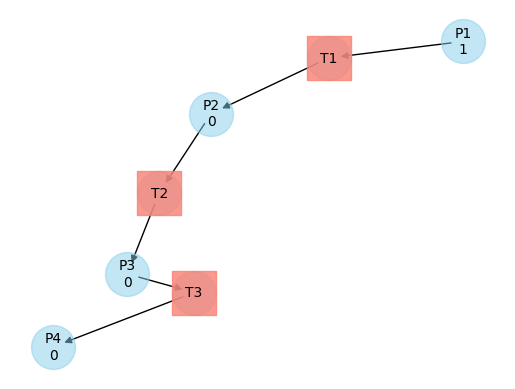

In [338]:
# Agregar arcos
for arco in data["arcos"]:
    G.add_edge(arco["desde"], arco["hacia"])

# Dibujar el grafo
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=1000, alpha=0.5, node_shape="o")
nx.draw_networkx_nodes(G, pos, nodelist=[transicion["id"] for transicion in data["transiciones"]], node_color="salmon", node_size=1000, alpha=0.8, node_shape="s")
nx.draw_networkx_edges(G, pos, arrows=True, edge_color="black", width=1, alpha=1)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
plt.axis("off")
plt.show()

Extraer información del JSON

In [339]:
lugares = data['lugares']
transiciones = data['transiciones']
arcos = data['arcos']

Crea el arreglo de marcación inicial

In [340]:
mi=[]
for lugar in lugares:
    mi.append(lugar["marcas"])
pila2=[]
pila= []
arbolacre = []
pila.append(mi)



In [341]:
print("MIU")
print(pila)
print(pila2)

MIU
[[1, 0, 0, 0]]
[]


Crear matrices D1 y D2 con ceros

In [342]:
p = len(lugares)
t = len(transiciones)

D1 = np.zeros((t, p))
D2 = np.zeros((t, p))

Llenar las matrices D1 y D2 con los pesos de los arcos

In [343]:
for arco in arcos:
    desde = arco['desde'] # actualiza los valores de desde hacia y peso
    hacia = arco['hacia']
    peso = arco['peso']
    if hacia[0] == 'T': # El arco va hacia una transicion
        i = int(hacia[1:]) - 1 
        j = int(desde[1:]) - 1
        D1[i][j] = peso

In [344]:
for arco in arcos:
    desde = arco['desde']
    hacia = arco['hacia']
    peso = arco['peso']
    if hacia[0] == 'P': # El arco va desde una transición a un lugar
        i = int(desde[1:]) - 1
        j = int(hacia[1:]) - 1
        D2[i][j] = peso

Imprimir la matriz D1 o D- (de entrada)

In [345]:
print("Matriz D1:")
print(D1)

Matriz D1:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


Imprimir la matriz D2 o D+ (de salida)

In [346]:
print("Matriz D2:")
print(D2)


Matriz D2:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [347]:
D = np.zeros((p, t))
D = D2 - D1
print(D)

[[-1.  1.  0.  0.]
 [ 0. -1.  1.  0.]
 [ 0.  0. -1.  1.]]


In [348]:
def transicion_habilitada(marcado_actual, D1, i):
    ma = marcado_actual[-1]
    habil = ma >= D1[i]
    habilitado = True 
    for j in range (len(ma)):
        if habil[j] == False:
            habilitado = False
    return habilitado

In [349]:
print("¿Transición habilitada?", transicion_habilitada(pila, D1, 0))

¿Transición habilitada? True


Funcion primer disparo para uno solo

In [350]:
def marcacion_proxima(marcado_actual, D1, D2, t):
    Bol = transicion_habilitada(marcado_actual, D1, t)
    marcadoproximo = np.zeros(len(lugares))
    if Bol == True:
        marcadoproximo = marcado_actual[-1] - D1[t] + D2[t]
        pila.append(marcadoproximo)
        primerm = pila[-1]
        arbol = [primerm, marcadoproximo, t]
        arbolacre.append(arbol)
        return marcadoproximo
    else:
        return (" transicion no habilidata", Bol)
    


In [351]:
print(marcacion_proxima(pila,D1,D2,0))
print(marcacion_proxima(pila,D1,D2,1))
print (pila)
print (pila2)
print (pila2)
print(arbolacre)


Funcion de Primer disparo para todos

In [352]:
# for j in transiciones:
#     for i in range(len(lugares)):
#         if mi[i] > D1[i][j]:
#             mip = mi[i] - D1[i][j] + D2[i][j]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [353]:
def dfs(marcado_actual, D1, D2, arbol_accesibilidad, transiciones, lugares):
    # Recorrer todas las transiciones posibles desde el marcado actual
    for t in range(len(transiciones)):
        # Verificar si la transición está habilitada
        if transicion_habilitada(marcado_actual, D1, t):
            # Calcular la marcación próxima
            marcado_proximo = calcular_marcado_proximo(marcado_actual, D1, D2, t)
            
            # Verificar si el marcado próximo ya ha sido explorado
            if marcado_proximo not in [estado[0] for estado in arbol_accesibilidad]:
                # Agregar el par (marcado, transición) al árbol de alcanzabilidad
                arbol_accesibilidad.append((marcado_actual, marcado_proximo, t))
                
                # Llamar a la función dfs recursivamente con el marcado próximo
                dfs(marcado_proximo, D1, D2, arbol_accesibilidad, transiciones, lugares)

def calcular_marcado_proximo(marcado_actual, D1, D2, t):
    # Calcular el marcado próximo después de ejecutar la transición t
    marcado_proximo = marcado_actual - D1[t] + D2[t]
    return marcado_proximo



